# 1. Install packages

In [54]:
# General Data Manipulation
import pandas
import numpy
import re

# Feature Engineering, Descriptives
from scipy.stats import ttest_ind
from nltk.corpus import stopwords
from collections import defaultdict

# NLP Modules
import gensim 
import spacy

# Supervised Learning Modules
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Package Results
from sklearn.externals import joblib

# Plotting
from matplotlib import pyplot
%matplotlib inline

# Read Data
data_in = pandas.read_csv('deceptive-opinion.csv')
stop = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')


# 2. Explore data

In [55]:
data_in.head(3).append(data_in.tail(3))

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama..."


In [56]:
data_in.pivot_table(
    columns=['deceptive','polarity'],
    index = ['hotel'],
    aggfunc = len).fillna(0)

source                                 text           \
deceptive        deceptive          truthful          deceptive            
polarity          negative positive negative positive  negative positive   
hotel                                                                      
affinia                 20       20       20       20        20       20   
allegro                 20       20       20       20        20       20   
amalfi                  20       20       20       20        20       20   
ambassador              20       20       20       20        20       20   
conrad                  20       20       20       20        20       20   
fairmont                20       20       20       20        20       20   
hardrock                20       20       20       20        20       20   
hilton                  20       20       20       20        20       20   
homewood                20       20       20       20        20       20   
hyatt                   20       20       20       20        20       20   
intercontinental        20       20       20       20        20       20   
james                   20       20       20       20        20       20   
knickerbocker           20       20       20       20        20       20   
monaco                  20       20       20       20        20       20   
omni                    20       20       20       20        20       20   
palmer                  20       20       20       20        20       20   
sheraton                20       20       20       20        20       20   
sofitel                 20       20       20       20        20       20   
swissotel               20       20       20       20        20       20   
talbott                 20       20       20       20        20       20   

                                    
deceptive        truthful           
polarity         negative positive  
hotel                               
affinia                20       20  
allegro                20       20  
amalfi                 20       20  
ambassador             20       20  
conrad                 20       20  
fairmont               20       20  
hardrock               20       20  
hilton                 20       20  
homewood               20       20  
hyatt                  20       20  
intercontinental       20       20  
james                  20       20  
knickerbocker          20       20  
monaco                 20       20  
omni                   20       20  
palmer                 20       20  
sheraton               20       20  
sofitel                20       20  
swissotel              20       20  
talbott                20       20

In [57]:
#Mean Length Funciton
def mean_len(group, mean = True):
    if mean == True:
        return numpy.mean(group.text.str.len())
    else:
        return group.text.str.len()

In [58]:
a = data_in.groupby(
    ['deceptive']).apply(
    mean_len, mean = True)

b = data_in.groupby(
    ['polarity']).apply(
    mean_len, mean = True)

c = data_in.groupby(
    ['deceptive','polarity']).apply(
    mean_len, mean = True)

d = data_in.groupby(
    ['hotel','polarity']).apply(
    mean_len, mean = True)

In [59]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019125 sha256=5caa9e7e3528ee4e6068b8095f0accc7c17aa307988d634f4016cd967c91f261
  Stored in directory: c:\users\zoe_k\appdata\local\pip\cache\wheels\64\69\41\6f820cf1d7488a0381a2059f66ec9f8f23116f7c67d18f3d8d
Successfully built en-core-web-sm
Note: you may need to restart the kernel to use updated packages.


# 3. Data transformation

In [60]:
# Create Instance and Add Data to NLP object.
data_nlp = data_in.copy()
import en_core_web_sm
nlp = en_core_web_sm.load()

In [61]:
parsed = nlp.pipe(iter(data_nlp['text']), batch_size=1, n_threads=4)

# Create Features
tokens, lemma, parts, stopword = [], [], [], []

for parsed_doc in parsed:
    tokens.append([n.text for n in parsed_doc])
    lemma.append([n.lemma_ for n in parsed_doc])
    parts.append([n.pos_ for n in parsed_doc])
    stopword.append([n.is_stop for n in parsed_doc])

# Assign Parsed into Dataframe
data_nlp['tokens'] = tokens     
data_nlp['tokens_stopwords'] = data_nlp['tokens'].apply(lambda x: [item for item in x if item not in stop])
data_nlp['lemma'] = lemma
data_nlp['pos'] = parts
data_nlp['stopword'] = stopword

# Describe resulting frame
data_nlp.head(2).append(data_nlp.tail(2))

,deceptive,hotel,polarity,source,text,tokens,tokens_stopwords,lemma,pos,stopword
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,"[We, stayed, for, a, one, night, getaway, with...","[We, stayed, one, night, getaway, family, thur...","[-PRON-, stay, for, a, one, night, getaway, wi...","[PRON, VERB, ADP, DET, NUM, NOUN, NOUN, ADP, N...","[True, False, True, True, True, False, False, ..."
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,"[Triple, A, rate, with, upgrade, to, view, roo...","[Triple, A, rate, upgrade, view, room, less, $...","[triple, a, rate, with, upgrade, to, view, roo...","[ADJ, DET, NOUN, ADP, NOUN, PART, NOUN, NOUN, ...","[False, True, False, True, False, True, False,..."
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...","[The, Palmer, House, Hilton, ,, while, it, loo...","[The, Palmer, House, Hilton, ,, looks, good, p...","[the, Palmer, House, Hilton, ,, while, -PRON-,...","[DET, PROPN, PROPN, PROPN, PUNCT, SCONJ, PRON,...","[True, False, False, False, False, True, True,..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama...","[As, a, former, Chicagoan, ,, I, 'm, appalled,...","[As, former, Chicagoan, ,, I, 'm, appalled, Am...","[as, a, former, Chicagoan, ,, -PRON-, be, appa...","[SCONJ, DET, ADJ, PROPN, PUNCT, PRON, AUX, VER...","[True, True, True, False, False, True, True, F..."


3.1 Create features 

In [62]:
# Set up dataframe columns for new metrics
pron_ct = []
noun_ct = []
punct_ct = []
verb_ct = []
# tag parts of speech
for row in data_nlp.pos:
    pron_ct.append(sum([i == 'PRON'  for i in row]))
    noun_ct.append(sum([i == 'NOUN'  for i in row]))
    punct_ct.append(sum([i == 'PUNCT'  for i in row]))
    verb_ct.append(sum([i == 'VERB'  for i in row]))

## Create Number of stopword
stop_row = []
for row in data_nlp.stopword:
    stop_row.append(sum(row))
    
# Create POS Counts
data_nlp['pron_ct'] = pron_ct
data_nlp['noun_ct'] = noun_ct
data_nlp['punct_ct'] = punct_ct
data_nlp['verb_ct'] = verb_ct
data_nlp['stoprow'] = stop_row
# Describe Data
data_nlp.head(2).append(data_nlp.tail(2))

,deceptive,hotel,polarity,source,text,tokens,tokens_stopwords,lemma,pos,stopword,pron_ct,noun_ct,punct_ct,verb_ct,stoprow
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,"[We, stayed, for, a, one, night, getaway, with...","[We, stayed, one, night, getaway, family, thur...","[-PRON-, stay, for, a, one, night, getaway, wi...","[PRON, VERB, ADP, DET, NUM, NOUN, NOUN, ADP, N...","[True, False, True, True, True, False, False, ...",6,28,13,4,58
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,"[Triple, A, rate, with, upgrade, to, view, roo...","[Triple, A, rate, upgrade, view, room, less, $...","[triple, a, rate, with, upgrade, to, view, roo...","[ADJ, DET, NOUN, ADP, NOUN, PART, NOUN, NOUN, ...","[False, True, False, True, False, True, False,...",1,15,9,2,16
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...","[The, Palmer, House, Hilton, ,, while, it, loo...","[The, Palmer, House, Hilton, ,, looks, good, p...","[the, Palmer, House, Hilton, ,, while, -PRON-,...","[DET, PROPN, PROPN, PROPN, PUNCT, SCONJ, PRON,...","[True, False, False, False, False, True, True,...",13,14,13,13,55
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama...","[As, a, former, Chicagoan, ,, I, 'm, appalled,...","[As, former, Chicagoan, ,, I, 'm, appalled, Am...","[as, a, former, Chicagoan, ,, -PRON-, be, appa...","[SCONJ, DET, ADJ, PROPN, PUNCT, PRON, AUX, VER...","[True, True, True, False, False, True, True, F...",35,39,29,36,166


3.2 Topic modelling

In [63]:
# helper function

def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gensim.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gensim.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Unsupervised Component. Reduce space into 300 topics. 
    topic_n = topic_n
    lsi = gensim.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi  

train_data = data_nlp.tokens_stopwords

built = build_model(
    train_data = train_data,
    topic_n = 300)

In [64]:
data_nlp_decomposed = pandas.DataFrame([dict(row) for row in built[0]])
topic_only = data_nlp_decomposed

# 4. Classification

In [65]:
# Setting Up Three Datasets
X1 = topic_only
X2 = pandas.concat(
    [topic_only,
     data_nlp[['pron_ct', 'noun_ct', 'punct_ct', 'verb_ct']]],
    axis = 1)
X3 = pandas.concat(
    [X2,
     pandas.get_dummies(data_nlp[['hotel','polarity']])],
    axis = 1)
Y = data_nlp.deceptive == 'deceptive'

In [66]:
# prepare configuration for cross validation test harness
seed = 4
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier(n_jobs = -1, n_estimators = 500)))

In [67]:
# evaluate each model in turn

def run_models(train_data, title):
    results = []
    names = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, train_data, Y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = pyplot.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    pyplot.boxplot(results)
    ax.set_xticklabels(names)
    pyplot.ylim(0,1)
    pyplot.show()

In [68]:
X1.shape

(1600, 300)

LR: 0.767500 (0.067881)
CART: 0.721875 (0.052085)
SVM: 0.810625 (0.039236)
RF: 0.745625 (0.066676)


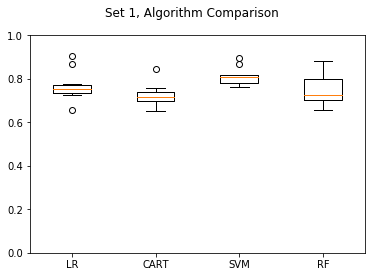

In [69]:
run_models(X1, title= 'Set 1, Algorithm Comparison')

In [70]:
X2.shape

(1600, 304)

LR: 0.738125 (0.060818)
CART: 0.726250 (0.056858)
SVM: 0.501250 (0.107631)
RF: 0.750000 (0.070045)


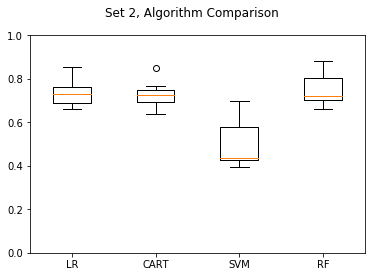

In [71]:
run_models(X2, title= 'Set 2, Algorithm Comparison')

In [72]:
X3.shape

(1600, 326)

LR: 0.458750 (0.120649)
CART: 0.726250 (0.043193)
SVM: 0.485625 (0.111595)
RF: 0.730000 (0.077248)


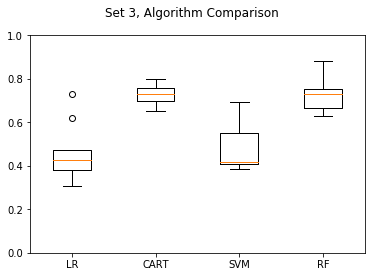

In [73]:
run_models(X3, title= 'Set 3, Algorithm Comparison')

In [74]:
tuned_parameters = [
    {'n_estimators' : [1000],
     'max_depth':[15,25,50,75],
     'criterion':['gini'],
    'min_samples_leaf':[50,100]
    }]

In [75]:
def run_rf(score, tuned_parameters, X, Y):
    
    grid_scores = []
    
    clf = GridSearchCV(
        RandomForestClassifier(n_jobs=-1),
        tuned_parameters,
        cv=10,
        scoring=score)
    
    clf.fit(X, Y)
    
    print(clf.best_estimator_)
    
    grid_scores = pandas.DataFrame({
    '  std' : clf.cv_results_['std_test_score'],
    " mean" : clf.cv_results_['mean_test_score'],
    'params': clf.cv_results_['params']
    })
    return clf, grid_scores

In [79]:
clf = run_rf(score = 'accuracy', tuned_parameters= tuned_parameters, X = X2, Y = Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [82]:
clf.cv_results_['accuracy']

KeyError: 'accuracy'

# 5. Data analysis

In [38]:
# set this to display the # of float places
pandas.set_option('display.float_format', lambda x: '%.6f' % x)

# extract best classifer for precision
importance = clf.best_estimator_.feature_importances_
# extract 
importance = clf.best_estimator_.feature_importances_
importance = pandas.DataFrame(
    importance,
    index=X2.columns, 
    columns=["Importance"])
# For each of the 750 Trees in forest, extract estimators to creator std deviaton
importance["Std"] = numpy.std(
    [tree.feature_importances_
     for tree in clf.best_estimator_.estimators_], axis=0)
importance = importance.sort_values('Importance', ascending=False)

In [ ]:
to_plot = importance.head(25)
x = range(to_plot.shape[0])
y = to_plot.ix[:, 0]
yerr = to_plot.ix[:, 1]
pyplot.bar(x, y, yerr=yerr, align="center")
pyplot.show()

In [41]:
selection = importance.head(3).index
x = []
for z in selection:
    data = pandas.DataFrame(built[3].show_topic(z-1), columns = ['Word','Weight'])
    data['topic'] = z
    x.append(data)
x = pandas.concat(x, axis=0)
x

,Word,Weight,topic
0,',0.221435,2
1,great,-0.174687,2
2,comfortable,-0.129059,2
3,beautiful,-0.116635,2
4,enjoyed,-0.114076,2
5,definitely,-0.112627,2
6,When,0.110079,2
7,wonderful,-0.109578,2
8,called,0.104569,2
9,helpful,-0.104243,2


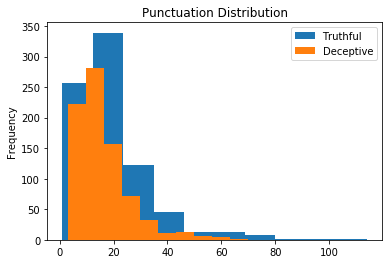

In [42]:
truthful = data_nlp[data_nlp.deceptive == "truthful"]
truthful['Truthful'] = truthful['punct_ct']

deceptive = data_nlp[data_nlp.deceptive != "truthful"]
deceptive['Deceptive'] = deceptive['punct_ct']

truthful['Truthful'].plot(legend = True, kind = 'hist')
deceptive['Deceptive'].plot(legend = True, title = "Punctuation Distribution",kind = 'hist')